In [86]:
from astroquery.jplhorizons import Horizons
import numpy as np
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import multiprocessing as mp
import os
import healpy as hp
import requests

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time
from astropy.io.votable import parse
from astropy.io import fits
from astropy.wcs import WCS
from astropy.wcs import NoConvergence
from astropy.table import Table, vstack

#from queryMPC import runMPCRequests
#from queryMPC import matchSingleVisit
#from plottingTools import makeStamps

pd.options.mode.chained_assignment = None  # default='warn'

In [209]:
from astroquery.imcce import Skybot
from astropy.coordinates import SkyCoord
from astropy.time import Time
import astropy.units as u
import pickle
import numpy as np

with open('A0b.pkl', 'rb') as f:
    PointingGroups = pickle.load(f)
PointingGroups.drop_duplicates('visit_id',inplace=True)
df = PointingGroups
allTimes = []
for i in range(len(PointingGroups)):
    date_obs = df['date_obs'].iloc[i].decode()#[2:-1]
    time_obj = Time(date_obs, format='iso', scale='utc')
    allTimes.append(time_obj.jd)
allTimes = np.array(allTimes)
timesMask = np.logical_and(allTimes>2458576.714,allTimes<2458577.70862527)
times = allTimes

ra = PointingGroups['ra'].values[timesMask]
dec = PointingGroups['dec'].values[timesMask]
i=0
#field = SkyCoord(ra[i]*u.deg, ra[i]*u.deg)
field = (ra[i],dec[i])
epoch = Time(times[i], format='jd')
Results = Skybot.cone_search(field, 90*u.arcmin, epoch, location='W84')

In [210]:
RA_rate = Results['RA_rate']
DEC_rate = Results['DEC_rate']
pixel = u.arcsec/.26
RA_rate = RA_rate.to(pixel/u.day)
DEC_rate = DEC_rate.to(pixel/u.day)

totalRate = np.linalg.norm([RA_rate,DEC_rate],axis=0)
Type = np.array([classtype[0:3] for classtype in np.array(Results['Type'])])
print(Results[Type=='KBO']['Name','RA','DEC','V'])

   Name            RA                 DEC          V  
                  deg                 deg         mag 
---------- ------------------ ------------------- ----
2013 GT136 216.49535749999998 -13.834343333333335 24.4
 2003 HZ56 215.31171416666663 -13.113056666666667 24.0
 2003 HY56 215.91163374999996 -14.367439444444445 24.2
 1999 HY11 215.00079458333332  -14.10660611111111 24.4
 2003 HC57 216.14113624999996 -14.651348055555555 22.2


In [156]:
with open('A0b.pkl', 'rb') as f:
    PointingGroups = pickle.load(f)
PointingGroups.drop_duplicates('visit_id',inplace=True)
df = PointingGroups
allTimes = []
for i in range(len(PointingGroups)):
    date_obs = df['date_obs'].iloc[i].decode()#[2:-1]
    time_obj = Time(date_obs, format='iso', scale='utc')
    allTimes.append(time_obj.jd)
allTimes = np.array(allTimes)
timesMask = np.logical_and(allTimes>2458576.714,allTimes<2458577.70862527)
times = allTimes
obj = Horizons(id='2013 GT136', location='W84', epochs=times) #ccd 43
#bj = Horizons(id='2003 HZ56', location='W84', epochs=times)
#obj = Horizons(id='2003 HY56', location='W84', epochs=times) #ccd 58
#obj = Horizons(id='2003 HC57', location='W84', epochs=times)
#obj = Horizons(id='1999 HY11', location='W84', epochs=times) #ccd 57
orbits = obj.ephemerides(quantities='1, 9')
orbits['visit'] = [int(visit) for visit in df['visit_id']]
orbits['x_pixel'] = -99
orbits['y_pixel'] = -99
orbits['ccd'] = -99
orbits['times'] = times
visitMask = [np.logical_and(orbits['visit']>=845580,orbits['visit']<=845682)]
orbits = orbits[visitMask]

/epyc/opt/anaconda/lib/python3.6/site-packages/astroquery/jplhorizons/core.py:598: UserWarning: The URI used in this query is very long and might have been truncated. The results of the query might be compromised. If you queried a list of epochs, consider querying a range.
  warnings.warn(('The URI used in this query is very long '


In [159]:
# Match the objects from MPC with pixel locations in the DECam NEO Survey
# Can comment this out if you don't want to select on slow movers (total_motion is arcsec/hr.)
# Cut the dataframe based on desired brightness and speed
# Generate the path to the data
dataPath = '/astro/store/pogo4/smotherh/DEEP/PointingGroups/Hyak/A0b/warps_calexp'
#dataPath = '/nvme/users/smotherh/DEEP/PointingGroups/A0b/warps'
cutDF = orbits
nightVisits = np.array(orbits['visit'])
def matchCcds(ccd):
    """This is a wrapper for matchSingleVisit.
    It allows it to easily run in parallel with a simple
    pool.map() call.
    """
    #visitDF = cutDF.query('visit_id == %i' % visit)
    #visitDF = visitDF.reset_index(drop=True)
    visitLocal=nightVisits[20]
    visitDF = matchSingleVisitCcd(cutDF,visitLocal,ccd,dataPath)
    print('Processed ccd {}'.format(ccd))
    return(visitDF)

def matchVisits(visit):
    """This is a wrapper for matchSingleVisit.
    It allows it to easily run in parallel with a simple
    pool.map() call.
    """
    #visitDF = cutDF.query('visit_id == %i' % visit)
    #visitDF = visitDF.reset_index(drop=True)
    ccd=43
    visitDF = matchSingleVisitCcd(cutDF,visit,ccd,dataPath)
    print('Processed visit {}'.format(visit))
    return(visitDF)

def matchSingleVisitCcd(visitDF,visit,ccd,dataPath,verbose=False):
    """Match the MPC object RA and DEC to pixel coorinates in the DECam NEO Survey
    Inputs-
        visitDF : Dataframe from runMPCRequests.
            It should only contain values from a single visit, although it may
            have multiple objects in that visit.
            Can be cut on magnitude, etc. if desired
        dataPath : Path to the DECam NEO Survey warps.
        verbose : Verbosity flag for print output

    Outputs-
        visitDF : Updated Dataframe with object->pixel relationships.
    """    

    i=ccd
    if verbose:
        print('Processing visit {}.'.format(visit))
    # Iterate over all moving objects (rows) in the visitDF
    obj_row = visitDF[visitDF['visit']==visit]
    # Set ra and dec and use them to generate a SkyCoord object
    ra = obj_row['RA']
    dec = obj_row['DEC']
    c = SkyCoord(ra, dec, frame='icrs', unit=(u.deg, u.deg))
    # Iterate over CCDs
    # CCD 2 and 61 are broken on DECam and should be skipped
    if (i==2 or i==31 or i==61):
        return(obj_row)
    if verbose:
        print('Processing ccd {} of 62.'.format(i))
    # Calculate the pixel values for the objects in the visit
    try:
        # Load only the fits header, changing the path for varying CCDs
        fitsHeader = fits.getheader('%s/%02i/0%s.fits' % (dataPath,i,visit),1)
        # Load the world coordinate system and find the pixel values
        w = WCS(fitsHeader)
        x_pix, y_pix = c.to_pixel(w)
        # If the returned pixel values are on the given CCD, save the object
        if (x_pix < 2010) and (x_pix > 0) and (y_pix < 4100) and (y_pix > 0):
            if verbose:
                print(obj_row['name'], ra, dec)
                print(x_pix, y_pix)
            obj_row['x_pixel'] = x_pix
            obj_row['y_pixel'] = y_pix
            obj_row['ccd'] = i
    except:
        return(obj_row)
    return(obj_row)

with mp.Pool(20) as pool:
    results = pool.map(matchVisits,nightVisits)
#with mp.Pool(20) as pool:
#    results = pool.map(matchCcds,range(1,63))
# Concatenate the results back into a single dataframe.
#results = results[0]

Processed visit 845618
Processed visit 845590
Processed visit 845582
Processed visit 845586
Processed visit 845616
Processed visit 845606
Processed visit 845588
Processed visit 845610
Processed visit 845600
Processed visit 845614
Processed visit 845591
Processed visit 845608
Processed visit 845592
Processed visit 845594
Processed visit 845584
Processed visit 845619
Processed visit 845598
Processed visit 845604
Processed visit 845602
Processed visit 845596
Processed visit 845580
Processed visit 845612
Processed visit 845587
Processed visit 845583
Processed visit 845620
Processed visit 845589
Processed visit 845617
Processed visit 845607
Processed visit 845593
Processed visit 845599
Processed visit 845622
Processed visit 845615
Processed visit 845581
Processed visit 845597
Processed visit 845601
Processed visit 845609
Processed visit 845611
Processed visit 845595
Processed visit 845585
Processed visit 845626
Processed visit 845613
Processed visit 845603
Processed visit 845624
Processed v

In [136]:
for i in range(62):
    foo = results[i]
    onCcd = foo[foo['ccd']>0]
    if len(onCcd)>0:
        print(onCcd['ccd'])


ccd
---
 57


In [160]:
allResults = vstack(results)
allResults = allResults[allResults['ccd']>0]
allResults[0]

targetname,datetime_str,datetime_jd,H,G,solar_presence,flags,RA,DEC,V,visit,x_pixel,y_pixel,ccd,times
---,---,d,mag,---,---,---,deg,deg,mag,,,,,
str19,str24,float64,float64,float64,str1,str1,float64,float64,float64,int64,float64,float64,int64,float64
500829 (2013 GT136),2019-Apr-03 05:09:05.668,2458576.714648935,7.4,0.15,,,216.47994,-13.82978,24.35,845580,678.0195563679521,3828.245208803341,43,2458576.714648935


In [194]:
mask = np.array(sorted(random.sample(range(1,len(allResults)),10)))
mask
print(len(allResults))

103


In [192]:
import random
(mask==88).any()

True

103
[  1  14  42  45  58  60  78  84  85  86  87  91  97 100]


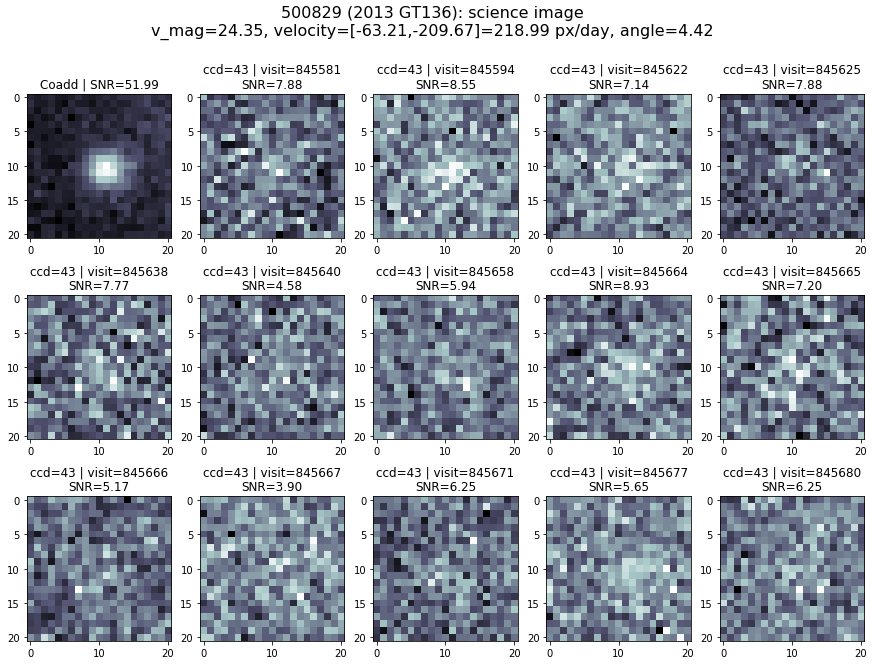

In [203]:
def makeStamps(singleObject,imagePath,imagePlane='science',numCols=5,
               stampSize=[31,31]):
    """Generate postage stamps of an MPC object in the Lori Allen Dataset.
    
    INPUT-
        name: This is the name of the object for which to find the image.
            Names come from the query_MPC notebook that pulls data down from
            the Minor Planets Center.

        objectList: A pandas dataframe as generated by query_MPC.

        imagePath: The path to the stack of images from which to make stamps.

        numCols: The number of columns in the postage stamp subplot.

        imagePlane : From which plane of the fits file should the stamps be
            made? Acceptable options:
            'science' : The science image plane
            'mask' : The mask image plane
            'variance' : The varience image plane
    """
    totalLength = len(singleObject)
    # Set the plane number used for loading the data from a fits file
    if imagePlane == 'science':
        imagePlaneNum = 1
    elif imagePlane == 'mask':
        imagePlaneNum = 2
    elif imagePlane == 'variance':
        imagePlaneNum = 3

    # Find the number of subplots to make. Add one for the coadd.
    #numPlots = len(singleObject)+1
    numPlots=15
    # Compute number of rows for the plot
    numRows = numPlots // numCols
    # Add a row if numCols doesn't divide evenly into numPlots
    if (numPlots % numCols):
        numRows+=1
    # Add a row if numRows=1. Avoids an error caused by ax being 1D.
    if (numRows==1):
        numRows+=1
    # Generate the subplots, setting the size with figsize
    fig,ax = plt.subplots(nrows=numRows,ncols=numCols,
                          figsize=[3*numCols,3.5*numRows])
    objectMag = np.max(singleObject['V'])
    # Find object velocity in pixels/day and the object angle in radians
    # total_motion is in arcsec/hr. DECam has .26arcsec/pixel ccd's. 24 hr/day.
    # Load initial and final object positions and calculate the trajectory angle
    findMotion = singleObject[singleObject['ccd']==singleObject['ccd'][0]]
    xi = np.array([findMotion['x_pixel'][0],
                   findMotion['y_pixel'][0]])
    xf = np.array([findMotion['x_pixel'][-1],
                   findMotion['y_pixel'][-1]])
    dx = xf-xi
    objectAngle = np.arctan2(dx[1],dx[0])
    dr = np.linalg.norm(dx)
    dt= findMotion['times'][-1] - findMotion['times'][0]
    objectVel = dr/dt
    xVel = dx[0]/dt
    yVel = dx[1]/dt
    
    if objectAngle<0:
        objectAngle += 2*np.pi
    figTitle = '{}: {} image\nv_mag={}, velocity=[{:.2f},{:.2f}]={:.2f} px/day, angle={:.2f}'
    fig.suptitle(figTitle.format(singleObject['targetname'][0],imagePlane,objectMag,xVel,yVel,objectVel,objectAngle),
                 fontsize=16)
    # Turn off all axes. They will be turned back on for proper plots.
    for row in ax:
        for column in row:
            column.axis('off')

    stampEdge = (stampSize[0]-1)/2
    size = stampSize[0]
    x = np.linspace(-stampEdge, stampEdge, size)
    y = np.linspace(-stampEdge, stampEdge, size)
    sigma_x = 1.4
    sigma_y = 1.4

    x, y = np.meshgrid(x, y)
    gaussian_kernel = (1/(2*np.pi*sigma_x*sigma_y) 
        * np.exp(-(x**2/(2*sigma_x**2) + y**2/(2*sigma_y**2))))
    sum_pipi = np.sum(gaussian_kernel**2)
    noise_kernel = np.zeros(stampSize)
    mask_lims = 7
    x_mask = np.logical_or(x>mask_lims, x<-mask_lims)
    y_mask = np.logical_or(y>mask_lims, y<-mask_lims)
    mask = np.logical_or(x_mask,y_mask)
    noise_kernel[mask] = 1

    # Set the axis indexes. These are needed to plot the stamp in the correct subplot
    axi=0
    axj=1
    print(totalLength)
    mask = np.array(sorted(random.sample(range(1,totalLength),14)))
    print(mask)
    maskedObject = singleObject[mask]
    for i,row in enumerate(singleObject):
        # Get the Lori Allen visit id from the single object list
        visit_id = row['visit']
        ccd = row['ccd']
        # Get the x and y values from the first object in the cut list. Round to an integer.
        objectLoc = np.round([row['x_pixel'],row['y_pixel']])
        # Open up the fits file of interest using the pre-defined filepath string
        hdul = fits.open(os.path.join(imagePath,'{:02}/0{}.fits'.format(ccd,visit_id)))

        # Generate the minimum and maximum pixel values for the stamps using stampSize
        xmin = int(objectLoc[0]-(stampSize[0]-1)/2+0.5)-1
        xmax = int(objectLoc[0]+(stampSize[0]-1)/2+0.5)
        ymin = int(objectLoc[1]-(stampSize[1]-1)/2+0.5)-1
        ymax = int(objectLoc[1]+(stampSize[1]-1)/2+0.5)

        im_dims = np.shape(hdul[imagePlaneNum].data)
        # Plot the stamp
        stampData = hdul[imagePlaneNum].data[ymin:ymax,xmin:xmax]
        #print(np.isnan(stampData))
        stampData[np.isnan(stampData)] = 0.0
        if i==0:
            coaddData=stampData
        else:
            coaddData+=stampData
        signal = np.sum(stampData*gaussian_kernel)
        noise = np.var(stampData*noise_kernel)
        SNR = signal/np.sqrt(noise*sum_pipi)
        if (mask==i).any():
            im = ax[axi,axj].imshow(stampData,cmap=plt.cm.bone)
            ax[axi,axj].set_title(
                'ccd={} | visit={}\nSNR={:.2f}'.format(ccd,visit_id,SNR))
            ax[axi,axj].axis('on')
            # Compute the axis indexes for the next iteration
            if axj<numCols-1:
                axj+=1
            else:
                axj=0
                axi+=1
    im = ax[0,0].imshow(coaddData,cmap=plt.cm.bone)
    signal = np.sum(coaddData*gaussian_kernel)
    noise = np.var(coaddData*noise_kernel)
    SNR = signal/np.sqrt(noise*sum_pipi)
    ax[0,0].axis('on')
    _=ax[0,0].set_title('Coadd | SNR={:.2f}'.format(SNR))
    return(coaddData)
coaddData = makeStamps(allResults,dataPath,stampSize=[21,21],numCols=5)
plt.savefig('2013_GT136_Sample.png')
#_ = makeStamps(allResults,dataPath,imagePlane='mask')
#_ = makeStamps(results,dataPath,imagePlane='variance')



In [13]:
results

targetname,datetime_str,datetime_jd,H,G,solar_presence,flags,RA,DEC,V,visit,x_pixel,y_pixel,ccd,times
---,---,d,mag,---,---,---,deg,deg,mag,,,,,
str19,str24,float64,float64,float64,str1,str1,float64,float64,float64,int64,int64,int64,int64,float64
500829 (2013 GT136),2019-Apr-03 05:09:05.668,2458576.714648935,7.4,0.15,,,216.47994,-13.82978,24.35,845580,678,3828,43,2458576.714648935
500829 (2013 GT136),2019-Apr-03 05:11:33.437,2458576.716359225,7.4,0.15,,,216.47991,-13.82977,24.35,845581,677,3827,43,2458576.7163592246
500829 (2013 GT136),2019-Apr-03 05:14:01.338,2458576.718071042,7.4,0.15,,,216.47988,-13.82976,24.35,845582,677,3827,43,2458576.7180710416
500829 (2013 GT136),2019-Apr-03 05:16:28.969,2458576.719779734,7.4,0.15,,,216.47986,-13.82975,24.35,845583,677,3827,43,2458576.7197797336
500829 (2013 GT136),2019-Apr-03 05:18:57.403,2458576.72149772,7.4,0.15,,,216.47983,-13.82974,24.35,845584,677,3826,43,2458576.72149772
500829 (2013 GT136),2019-Apr-03 05:21:25.273,2458576.723209178,7.4,0.15,,,216.4798,-13.82974,24.35,845585,677,3826,43,2458576.723209178
500829 (2013 GT136),2019-Apr-03 05:23:52.826,2458576.724916968,7.4,0.15,,,216.47978,-13.82973,24.35,845586,677,3826,43,2458576.7249169676
500829 (2013 GT136),2019-Apr-03 05:26:21.680,2458576.726639815,7.4,0.15,,,216.47975,-13.82972,24.35,845587,677,3825,43,2458576.7266398147


In [145]:
from skimage import measure
center_thresh = 0.03
x_peak_offset, y_peak_offset = [2,2]
stamps = coaddData
s = stamps - np.min(stamps)
s /= np.sum(s)
s = np.array(s, dtype=np.dtype('float64')).reshape(21,21)
mom = measure.moments_central(s, center=(10,10))
mom_list = [mom[2, 0], mom[0, 2], mom[1, 1], mom[1, 0], mom[0, 1]]
peak_1, peak_2 = np.where(s == np.max(s))

In [146]:
print(mom_list)
print(peak_1, peak_2)

[28.590459257829934, 30.768881161362515, -1.1698411820834735, -0.21762166520420578, 1.184819403108122]
[10] [11]


In [15]:
print(mom_list)
print(peak_1, peak_2)

[28.27251375076594, 28.20129837351851, 0.5492855807533488, 0.1530456606997177, 0.5972871736739762]
[11] [11]


In [100]:
print(mom_list)
print(peak_1, peak_2)

[25.45376499183476, 25.866023462906014, 0.1995414753910154, 0.08751042431686074, -0.17821833962807432]
[10] [10]


In [147]:
mom

array([[ 9.99999982e-01,  1.18481940e+00,  3.07688812e+01,
         6.50558268e+01],
       [-2.17621665e-01, -1.16984118e+00, -1.37527845e+01,
        -7.55450736e+01],
       [ 2.85904593e+01,  3.44737644e+01,  1.06276206e+03,
         2.16410674e+03],
       [-2.16750318e+01, -6.06942558e+01, -9.34540561e+02,
        -3.19535719e+03]])

In [150]:
np.sqrt(35)*.26

1.5381807436059003